#### Input data
Define standards absorbance and concentration

Define unknown absorbances

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd

input_fname = 'PS_data_0.xlsx' 
#input_sheet = '021125'
#input_sheet = '021325'
input_sheet = '022125'
# comment out appropriate lines below when swapping dates

output_fname = f'PS_output_{input_sheet}.xlsx'
output_sheet_lb = f'C_lb_{input_sheet}'
output_sheet_tb = f'C_tb_{input_sheet}'

# Read in the row data from Excel
df = pd.read_excel(input_fname, input_sheet)

# Show the first few rows of the data
print(df.head())

# loosely-bound (lb) and tightly-bound (tb) data
## 021125 ##
#A_lb0  = df.iloc[4:6, 1:].values  # indexing excludes the last index
#A_tb0  = df.iloc[7, 1:].values
## convert to numeric
#A_lb   = np.vectorize(lambda x: pd.to_numeric(x, errors='coerce'))(A_lb0)  # 2D array
#A_tb   = pd.to_numeric(A_tb0, errors='coerce')
## 021325 ##
#A_lb0  = df.iloc[4, 1:].values
#A_tb0  = df.iloc[6:8, 1:].values  # indexing excludes the last index
# convert to numeric
#A_lb   = pd.to_numeric(A_lb0, errors='coerce')
#A_tb   = np.vectorize(lambda x: pd.to_numeric(x, errors='coerce'))(A_tb0)  # 2D array
## 022125 ##
A_lb_tmp  = df.iloc[4:7, 1:-1].values  # removes the first and last column (last is nan)
A_tb_tmp  = df.iloc[8:11, 1:-1].values  
# convert to numeric
A_lb0   = np.vectorize(lambda x: pd.to_numeric(x, errors='coerce'))(A_lb_tmp)  # 2D array
A_tb0   = np.vectorize(lambda x: pd.to_numeric(x, errors='coerce'))(A_tb_tmp)  # 2D array

###   Do not change anything below here   ###

# standards
C_std_tmp  = df.iloc[0, 1:].values  # (row 1, all columns but first)
A_std_tmp  = df.iloc[1, 1:].values  

# convert to numerics
C_std0  = pd.to_numeric(C_std_tmp, errors='coerce') 
A_std0  = pd.to_numeric(A_std_tmp, errors='coerce')

# detection limit
lower_limit = 10  # ug/mL
upper_limit = 100

# flag to force line of best fit to intersect zero
force_zero = 1

      Unnamed: 0        1       2       3       4       5       6      7
0  Concentration  100.000  80.000  60.000  40.000  20.000  10.000  0.000
1              A    0.162   0.244   0.376   0.191   0.168   0.164  0.108
2            NaN      NaN     NaN     NaN     NaN     NaN     NaN    NaN
3             LB   40.000  20.000  14.000  10.000   7.000   5.000    NaN
4              B    0.095   0.117   0.097   0.091   0.091   0.082    NaN


In [2]:
print(C_std)
print(A_std)
print(A_lb)
print(A_tb)

NameError: name 'C_std' is not defined

In [22]:
### Subtract the blank 

subtract_blank = 1

if (subtract_blank == 1):
    # Define the blank absorbance
    blank = A_std0[-1]  # Last index for standards
    
    # Subtract blank absorbance from the data
    def subtract_blank(data, blank):
        return [value - blank for value in data]
    
    # Adjust data by subtracting the blank
    A_std = subtract_blank(A_std0, blank)
    A_lb = subtract_blank(A_lb0, blank)
    A_tb = subtract_blank(A_tb0, blank)
else:
    A_std = A_std0
    A_lb = A_lb0
    A_tb = A_tb0

print(A_std)

[0.054000000000000006, 0.136, 0.268, 0.083, 0.06000000000000001, 0.05600000000000001, 0.0]


#### Fit a line to the data

The fit will be linear at low concentrations (DuBois 1956)

In [19]:
# fit the standards 
coefs = poly.polyfit(A_std, C_std, 1)  # 1st degree (linear)

# This forces the fit line to intersect (0,0)
if force_zero == 1:
    coefs[0] = 0

# create line of best fit 
C_fit = poly.polyval(A_std, coefs)  # [ug/mL]
print('coefficients: ', coefs, '\n')

# function to determine concentration of unknown samples
def solve_conc(y):
    return poly.polyval(y, coefs)

# determine concentration of unknown samples [ug protein/mL buffer]
C_lb = solve_conc(A_lb)  # [ug/mL]
C_tb = solve_conc(A_tb)  # [ug/mL]
print('concentration[ug/mL]: ', C_lb)

coefficients:  [  0.         184.62092813] 

concentration[ug/mL]:  [[-2.40007207  1.66158835 -2.03083021 -3.13855578 -3.13855578 -4.80014413]
 [-3.50779763 -1.10772557 -0.55386278 -0.55386278  2.58469299 -3.69241856]
 [ 4.06166042  1.66158835  4.24628135 -2.03083021  5.53862784 -7.38483713]]


#### Solve for R-squared
This applies to the standard data 

In [20]:
# How good is the fit?
# Solve for the coefficient of determination (R-squared)
corr_matrix = np.corrcoef(C_std, C_fit)  # (actual, predict)
corr = corr_matrix[0,1]
R_sq = corr**2
print('R^2: ', R_sq)

R^2:  0.18402232785135375


In [21]:
# check lower limit
if np.any(C_lb < lower_limit) == True:
    print('WARNING: Some LB concentrations are lower than the lower limit.')
    print(C_lb)
if np.any(C_tb < lower_limit) == True:
    print('WARNING: Some TB concentrations are lower than the lower limit.')
    print(C_tb)

# check upper limit
if np.any(C_lb > upper_limit) == True:
    print('WARNING: Some LB concentrations are highter than the upper limit.')
    print(C_lb)
if np.any(C_tb > upper_limit) == True:
    print('WARNING: Some TB concentrations are highter than the upper limit.')
    print(C_tb)

[[-2.40007207  1.66158835 -2.03083021 -3.13855578 -3.13855578 -4.80014413]
 [-3.50779763 -1.10772557 -0.55386278 -0.55386278  2.58469299 -3.69241856]
 [ 4.06166042  1.66158835  4.24628135 -2.03083021  5.53862784 -7.38483713]]
[[24.73920437 16.80050446 21.96989045 30.09321129 35.26259727 -1.2923465 ]
 [20.12368117 14.40043239 -0.73848371 -4.24628135  9.23104641 14.40043239]
 [ 5.35400692 10.33877198 -6.64635341 -1.47696743  3.69241856 11.44649754]]


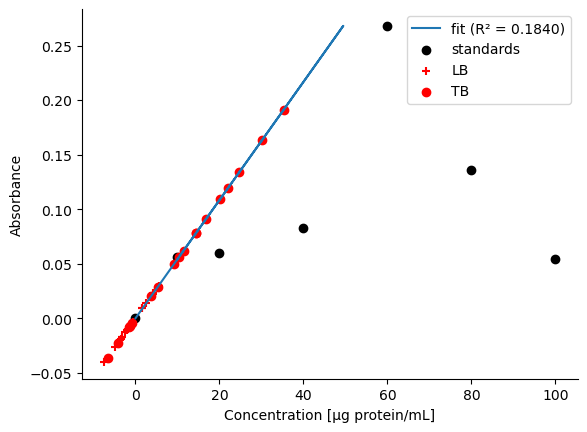

In [27]:
# plot line of best fit and standard data
plt.plot(C_fit, A_std, label = 'fit')       # line of best fit from standard data
plt.scatter(C_std, A_std, c='black', label = 'standard')     # standard data

# Plot unknown data
plt.scatter(C_lb, A_lb, c='red', marker='+', label = 'LB')  # loosely-bound
plt.scatter(C_tb, A_tb, c='red', marker='o', label = 'TB')  # tightly-bound

# axes labels
plt.xlabel("Concentration [\u03bcg protein/mL]")
plt.ylabel("Absorbance")
plt.legend(['fit (R\u00b2 = %.4f)' % R_sq,'standards','LB', 'TB']) 

# remove outer borderI
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(f'Std_curve_{input_sheet}.png')

In [25]:
print(solve_conc(0))

0.0


Save concentrations

In [24]:
# reshape C_tb to be one row, not one column
if C_tb.shape == (6,):
    C_tb = C_tb.reshape(1, -1)
if C_lb.shape == (6,):
    C_lb = C_lb.reshape(1, -1)

# Convert 2D arrays to DataFrame and save to Excel
df_C_lb = pd.DataFrame(C_lb)
df_C_tb = pd.DataFrame(C_tb)

# Save to Excel file
with pd.ExcelWriter(output_fname) as writer:
    df_C_lb.to_excel(writer, sheet_name = output_sheet_lb)  
    df_C_tb.to_excel(writer, sheet_name = output_sheet_tb)
